In [1]:
import numpy as np
import pandas as pd
import seaborn
import sklearn
from sklearn.model_selection import train_test_split


In [2]:
url='https://raw.githubusercontent.com/niloytanvir/heart-failure-data/main/Data/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(url)

In [3]:
x = data.iloc[:,:-1]
y = data.iloc[:,12]

In [4]:
x.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [5]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: DEATH_EVENT, dtype: int64

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [7]:
FIT_FEATURES = SelectKBest(score_func = f_classif)

In [8]:
FIT_FEATURES.fit(x,y)

SelectKBest(k=10, score_func=<function f_classif at 0x7f7581a65dd0>)

In [9]:
Score_Col = pd.DataFrame(FIT_FEATURES.scores_ , columns=['score_val'])

In [10]:
Score_Col

,score_val
0,20.435946
1,1.310096
2,1.173259
3,0.001121
4,23.094063
5,1.881937
6,0.718880
7,28.158492
8,11.765331
9,0.005534


In [11]:
Name_Col = pd.DataFrame(x.columns)

In [12]:
top_features = pd.concat([Name_Col,Score_Col], axis=1)

In [13]:
top_features

,0,score_val
0,age,20.435946
1,anaemia,1.310096
2,creatinine_phosphokinase,1.173259
3,diabetes,0.001121
4,ejection_fraction,23.094063
5,high_blood_pressure,1.881937
6,platelets,0.718880
7,serum_creatinine,28.158492
8,serum_sodium,11.765331
9,sex,0.005534


In [14]:
top_features.nlargest(8,'score_val')

,0,score_val
11,time,114.181264
7,serum_creatinine,28.158492
4,ejection_fraction,23.094063
0,age,20.435946
8,serum_sodium,11.765331
5,high_blood_pressure,1.881937
1,anaemia,1.310096
2,creatinine_phosphokinase,1.173259


In [15]:
Col_to_Drop = ['smoking', 'sex', 'platelets', 'diabetes']

In [16]:
x = x.drop(Col_to_Drop, axis= 1)

In [17]:
x.head()

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium,time
0,75.0,0,582,20,1,1.9,130,4
1,55.0,0,7861,38,0,1.1,136,6
2,65.0,0,146,20,0,1.3,129,7
3,50.0,1,111,20,0,1.9,137,7
4,65.0,1,160,20,0,2.7,116,8


In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.20, random_state=101)

In [19]:

batchSize = [10, 20, 40, 60, 80, 100]
epochs = [10, 30, 50,100,200,300]
optimizer = ['SGD','Adadelta', 'RMSprop', 'Adagrad','Adam']


In [20]:
# Create the param grid
param_grid = { 'batch_size' : batchSize,
               'epochs' : epochs,
               'optimizer' : optimizer}
print(param_grid)

{'batch_size': [10, 20, 40, 60, 80, 100], 'epochs': [10, 30, 50, 100, 200, 300], 'optimizer': ['SGD', 'Adadelta', 'RMSprop', 'Adagrad', 'Adam']}


In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [22]:
# F1 Score custom metrics
from keras import backend as K
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
# Function to create model,for KerasClassifier
def create_model(optimizer='adam'):
    #defining my model
    mymodel = Sequential()
    mymodel.add(Dense(4, input_dim=8, activation='relu'))
    mymodel.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    mymodel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy',f1_score,tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    return mymodel


In [24]:
# create model
model = KerasClassifier(build_fn=create_model)

In [25]:
from sklearn.model_selection import GridSearchCV
Grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)

In [26]:
Grid_result = Grid.fit(xtrain, ytrain)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 21.1min finished


Epoch 1/300
12/12 [==============================] - 13s 2ms/step - loss: 63.0152 - accuracy: 0.5392 - f1_score: 0.4064 - precision: 0.3216 - recall: 0.4443
Epoch 2/300
12/12 [==============================] - 0s 1ms/step - loss: 46.4732 - accuracy: 0.5462 - f1_score: 0.4001 - precision: 0.4042 - recall: 0.5592
Epoch 3/300
12/12 [==============================] - 0s 2ms/step - loss: 40.4271 - accuracy: 0.5795 - f1_score: 0.4282 - precision: 0.4005 - recall: 0.5521
Epoch 4/300
12/12 [==============================] - 0s 1ms/step - loss: 32.9829 - accuracy: 0.5769 - f1_score: 0.4374 - precision: 0.3989 - recall: 0.5208
Epoch 5/300
12/12 [==============================] - 0s 1ms/step - loss: 22.1304 - accuracy: 0.6346 - f1_score: 0.4377 - precision: 0.4023 - recall: 0.4996
Epoch 6/300
12/12 [==============================] - 0s 2ms/step - loss: 21.7807 - accuracy: 0.6083 - f1_score: 0.3591 - precision: 0.4081 - recall: 0.4740
Epoch 7/300
12/12 [==============================] - 0s 2ms/ste

In [27]:
Grid_result.best_params_

{'batch_size': 20, 'epochs': 300, 'optimizer': 'Adam'}

In [28]:
print (f'Train Accuracy - : {Grid_result.score(xtrain,ytrain):.3f}')
print (f'Test Accuracy - : {Grid_result.score(xtest,ytest):.3f}')

12/12 [==============================] - 1s 1ms/step - loss: 0.4681 - accuracy: 0.8033 - f1_score: 0.6673 - precision: 0.5868 - recall: 0.6561
Train Accuracy - : 0.803
3/3 [==============================] - 1s 4ms/step - loss: 0.3636 - accuracy: 0.8500 - f1_score: 0.7000 - precision: 0.5870 - recall: 0.6560
Test Accuracy - : 0.850


In [29]:
from sklearn import metrics

In [30]:
pred_train=Grid_result.predict(xtrain)
pred_test=Grid_result.predict(xtest)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

In [31]:
train_acc = metrics.accuracy_score(ytrain, pred_train)
test_acc = metrics.accuracy_score(ytest, pred_test)
train_f1 = metrics.f1_score(ytrain, pred_train)
test_f1 = metrics.f1_score(ytest, pred_test)
train_recall = metrics.recall_score(ytrain, pred_train)
test_recall = metrics.recall_score(ytest, pred_test)
train_precision = metrics.precision_score(ytrain, pred_train)
test_precision = metrics.precision_score(ytest, pred_test)
train_loss = metrics.log_loss(ytrain, pred_train)
test_loss = metrics.log_loss(ytest, pred_test)


print(f'\nTrain Accuracy: {train_acc:.3f}')
print(f'\nTest Accuracy: {test_acc:.3f}')
print(f'\nTrain F1 Score: {train_f1:.3f}')
print(f'\nTest F1 Score: {test_f1:.3f}')
print(f'\nTrain recall Score: {train_recall:.3f}')
print(f'\nTest recall Score: {test_recall:.3f}')
print(f'\nTrain precision Score: {train_precision:.3f}')
print(f'\nTest precision Score: {test_precision:.3f}')
print(f'\nTrain loss Score: {train_loss:.3f}')
print(f'\nTest loss Score: {test_loss:.3f}')


Train Accuracy: 0.803

Test Accuracy: 0.850

Train F1 Score: 0.689

Test F1 Score: 0.710

Train recall Score: 0.642

Test recall Score: 0.733

Train precision Score: 0.743

Test precision Score: 0.688

Train loss Score: 6.792

Test loss Score: 5.181


In [32]:
import matplotlib.pyplot as plt 

In [33]:
r_probs = [0 for _ in range(len(ytest))]
grid_probs = Grid_result.predict_proba(xtest)

In [34]:
grid_probs = grid_probs[:,1]

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

In [36]:
r_auc = roc_auc_score(ytest,r_probs)
grid_auc = roc_auc_score(ytest,grid_probs)


In [37]:
print('Random (chance) prediction: AUROC = %.3f' %(r_auc))
print('Grid search test: AUROC = %.3f' %(grid_auc))


Random (chance) prediction: AUROC = 0.500
Grid search test: AUROC = 0.895


In [38]:
r_fpr , r_tpr, _ = roc_curve(ytest,r_probs)
grid_fpr , grid_tpr, _ = roc_curve(ytest,grid_probs)

<function matplotlib.pyplot.show>

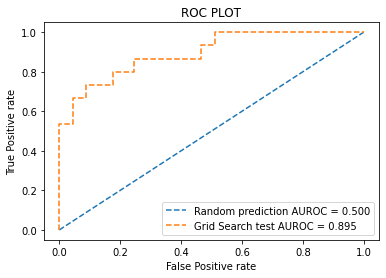

In [41]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction AUROC = %0.3f' %r_auc)
plt.plot(grid_fpr, grid_tpr, linestyle='--', label='Grid Search test AUROC = %0.3f' %grid_auc)


plt.title('ROC PLOT')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show